In [132]:
import pandas as pd
import numpy as np
import warnings
import keras
from keras.src.models import Sequential
from keras.src.layers import InputLayer, Dense
from keras.src.optimizers import Adam
import tensorflow as tf

warnings.filterwarnings("ignore")  #suppress warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

Nous avons codé un Perceptron de zéro, mais heureusement il existe des librairies qui nous font gagner du temps quand il s'agit de coder des réseaux de neurones. Et aujourd'hui nous allons recoder le même perceptron mais avec la librairie Keras, et vous allez voir c'est beaucoup plus simple !

# Jeu de données
Nous utiliserons le même jeu de données que lors du TP de programmation du Perceptron de zéro. Vous allez donc devoir réaliser les mêmes pré-traitements !

In [133]:
# add header names
headers = ['age', 'sex', 'chest_pain', 'resting_blood_pressure',
           'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
           'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', "slope of the peak",
           'num_of_major_vessels', 'thal', 'heart_disease']

heart_df = pd.read_csv('datasets/heart.dat', sep=' ', names=headers)
print(len(heart_df))

270


In [134]:
heart_df.head()

,age,sex,chest_pain,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg_results,max_heart_rate_achieved,exercise_induced_angina,oldpeak,slope of the peak,num_of_major_vessels,thal,heart_disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [135]:
# Compte le nombre de valeur nulle
heart_df.isna().sum()

age                        0
sex                        0
chest_pain                 0
resting_blood_pressure     0
serum_cholestoral          0
fasting_blood_sugar        0
resting_ecg_results        0
max_heart_rate_achieved    0
exercise_induced_angina    0
oldpeak                    0
slope of the peak          0
num_of_major_vessels       0
thal                       0
heart_disease              0
dtype: int64

In [136]:
heart_df.dtypes

age                        float64
sex                        float64
chest_pain                 float64
resting_blood_pressure     float64
serum_cholestoral          float64
fasting_blood_sugar        float64
resting_ecg_results        float64
max_heart_rate_achieved    float64
exercise_induced_angina    float64
oldpeak                    float64
slope of the peak          float64
num_of_major_vessels       float64
thal                       float64
heart_disease                int64
dtype: object

In [137]:
# TODO Suppression de la colonne cible de X
X = heart_df.drop(columns=['heart_disease'])

# TODO Remplacer 1 par 0, et 2 par 1 dans la colonne heart_disease
heart_df['heart_disease'] = heart_df['heart_disease'].replace(1, 0)
heart_df['heart_disease'] = heart_df['heart_disease'].replace(2, 1)

# TODO Reshape de Y pour qu'il soit sous forme de ligne de une colonnes
Y = heart_df['heart_disease'].values.reshape(-1, 1)

# TODO Split de X et Y en train et test set avec train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=2)

# TODO Normalisation des données en utilisant StandardScaler
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of Xtrain set is {Xtrain.shape}")
print(f"Shape of Xtest set is {Xtest.shape}")
print(f"Shape of Ytrain label is {ytrain.shape}")
print(f"Shape of Ytest labels is {ytest.shape}")

Shape of Xtrain set is (216, 13)
Shape of Xtest set is (54, 13)
Shape of Ytrain label is (216, 1)
Shape of Ytest labels is (54, 1)


# Création du Perceptron en utilisant Keras
## La Classe Sequential
La Classe Sequential est une classe permettant de créer un réseau de neurones de façon séquentielle. C'est-à-dire, couche par couche.
## Couche d'entrée
Nous avons déjà parlé de shape lors de la création d'un Perceptron de zéro. Ici, nous avons les mêmes contraintes. De manière générale, la couche d'entrée a autant de noeuds que de caractéristiques utilisées pour réaliser la prédiction ! Dans notre cas ce sera donc 13.

## Couche de sortie
La couche de sortie est la couche qui retourne la prédiction. Cette couche doit avoir un nombre de noeuds défini selon le nombre de classe que l'on souhaite prédire ! Par exemple si vous souhaitez entrainer votre modèle pour prédire si sur une image il y a un chat, un chien, un cheval, ou un lapin, vous avez donc 4 classes. La couche de sortie aura ainsi 4 nœuds ! Dont chaque noeud aura pour valeur la probabilité d'être une des classes. 
Il y a une exception ! Dans le cas où vous avez deux classes, vous pouvez procéder comme expliqué juste avant, ou alors, vous pouvez n'avoir qu'un nœud de sortie. Avec l'unique noeud ayant pour valeur la probabilité d'être la classe 0 par exemple. Car vous pourrez avoir la probabilité d'être de la classe 1 avec  : 
$$
P(1) = 1 - P(0) 
$$ 
Cependant ce n'est pas magique, tout dépend des données. Reprenons le premier exemple avec les animaux. Vous aurez des colonnes de descriptions, et une colonne décrivant l'animal. Tout d'abord, il faudra transformer toutes les valeurs en valeurs numériques. Supposons que vous avez "Chien", "Chat", "Cheval" et "Lapin" en valeurs possibles pour la colonne cible. Vous allez devoir transformer valeur "Chien" par exemple, en un tableau décrivant la probabilité d'appartenir à chaque classe. Dans le cas où nous avons la valeur "Chien" nous le transformerons donc en [1,0,0,0]. Soit les probabilités d'appartenir à chaque classe. <br> <br>

Dans le cas des maladies du cœur, nous avons donc 2 classes : Malade(1) et pas malade(0).
Nous avons fait le choix de ne pas utiliser de tableau, mais de directement avoir la probabilité d'être malade du cœur comme valeur.
Si nous avions fait l'autre choix, nous aurions eu des tableaux de la forme [1,0] quand la personne est malade et [0,1] quand elle ne l'est pas.

In [138]:
# TODO Création du modèle Sequential
model = keras.Sequential()
# TODO Création de la couche d'entrée
model.add(InputLayer(input_shape=(Xtrain.shape[1],)))
# TODO Création d'une couche avec un neurone et une fonction d'activation sigmoid
model.add(Dense(1, activation='sigmoid'))
# TODO Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [139]:
# TODO, Lancer l'apprentissage avec 100 epochs, et en précisant le jeu de données de test en tant que jeu de validation
history = model.fit(Xtrain, ytrain, epochs=100, verbose=1, validation_data=(Xtest, ytest))

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7125 - loss: 0.5737 - val_accuracy: 0.6296 - val_loss: 0.6686
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7282 - loss: 0.5459 - val_accuracy: 0.6667 - val_loss: 0.6615
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7110 - loss: 0.5670 - val_accuracy: 0.6667 - val_loss: 0.6550
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7100 - loss: 0.5470 - val_accuracy: 0.6667 - val_loss: 0.6487
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7420 - loss: 0.5348 - val_accuracy: 0.6667 - val_loss: 0.6426
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7181 - loss: 0.5464 - val_accuracy: 0.6667 - val_loss: 0.6366
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7503 - loss: 0.5294 - val_accuracy: 0.6667 - val_loss: 0.6306
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7496 - loss: 0.5148 - val_accuracy: 0.6852 - val_loss: 0.625

In [140]:
# Fonction permettant d'affocher l'évolution d'une des métrics du modèle (score ou loss)
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.ylabel(f"{metric}")
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

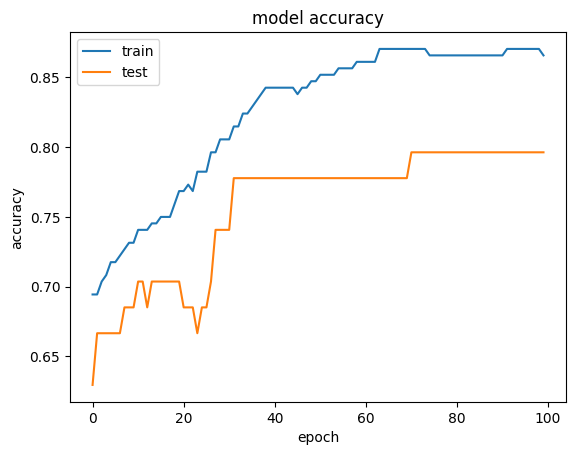

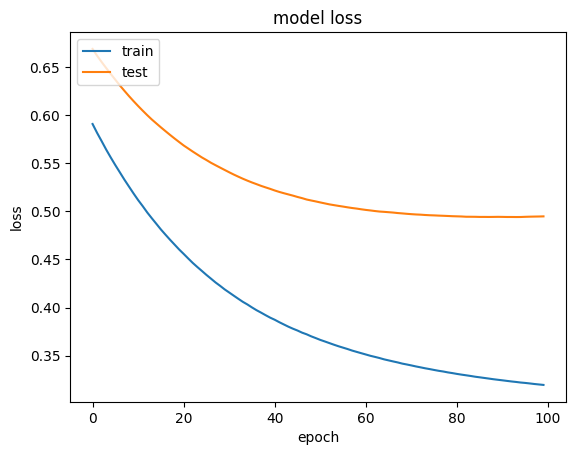

In [141]:
# TODO, Afficher la courbe d'évolution de l'accuracy
plot_history(history, "accuracy")
# TODO, Afficher la courbe d'évolution de la loss
plot_history(history, "loss")

# Comment modifier le learning rate ?
Afin de modifier le learning rate, vous devez passer via l'Optimiseur.
Vous devez donc d'abord en créer un. Par défaut quand vous préciser un optmiser dans la fonction model.compile comme "adam" certaines valeurs sont mise par défaut.

In [142]:
# TODO Création de l'optimizer
opt = Adam(learning_rate=0.001)
# TODO Création du modèle Sequential
model = keras.Sequential()
# TODO Création de la couche d'entrée
model.add(InputLayer(input_shape=(Xtrain.shape[1],)))
# TODO Ajout d'une couche Dense de 1 neurone avec une fonction d'activation sigmoid
model.add(Dense(1, activation='sigmoid'))
# TODO Compilation du modèle, en précisant bien notre optimzer créé juste au dessus
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [143]:
# TODO Lancer l'entrainement du modèle
history = model.fit(Xtrain, ytrain, epochs=100, verbose=1, validation_data=(Xtest, ytest))

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5984 - loss: 0.7353 - val_accuracy: 0.5370 - val_loss: 0.7954
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5877 - loss: 0.7145 - val_accuracy: 0.5370 - val_loss: 0.7877
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6230 - loss: 0.6927 - val_accuracy: 0.5741 - val_loss: 0.7802
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6390 - loss: 0.6718 - val_accuracy: 0.5741 - val_loss: 0.7730
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6304 - loss: 0.6823 - val_accuracy: 0.5926 - val_loss: 0.7659
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6421 - loss: 0.6261 - val_accuracy: 0.6111 - val_loss: 0.7589
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6831 - loss: 0.6133 - val_accuracy: 0.6111 - val_loss: 0.7523
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6539 - loss: 0.6859 - val_accuracy: 0.6111 - val_loss: 0.7

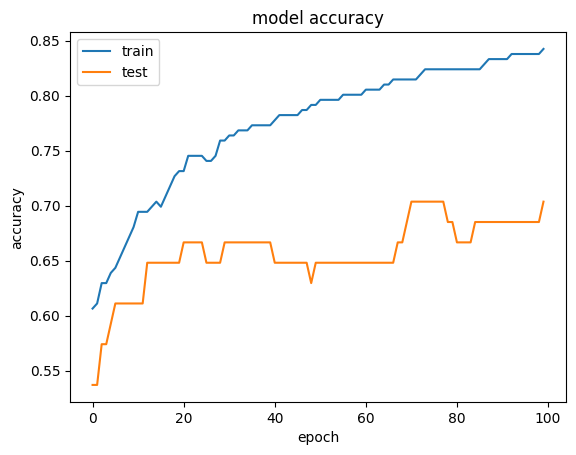

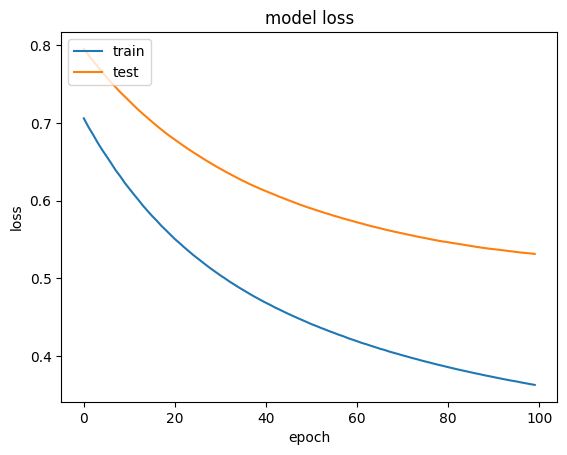

In [144]:
# TODO Afficher l'évolution de l'accuracy
plot_history(history, "accuracy")
# TODO Afficher l'évolution de la fonction de coût
plot_history(history, "loss")

Essayez de modifier votre learning rate pour avoir de meilleurs résultats !

# Avec plus de nœuds / couches ?
Ajoutez plus de nœuds / couches à votre modèle pour en observer l'impact

In [145]:
# TODO Création du modèle Sequential
model = keras.Sequential()
# TODO Création de la couche d'entrée
model.add(InputLayer(input_shape=(Xtrain.shape[1],)))
# TODO Ajout d'une ou plusieurs couches denses
model.add(Dense(10))
# TODO Ajout d'une couche Dense de 1 neurone avec une fonction d'activation sigmoid
model.add(Dense(1, activation='sigmoid'))
# TODO Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 10)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

(None, 13)


In [146]:
# TODO Lancer l'entrainement du modèle
history = model.fit(Xtrain, ytrain, epochs=100, verbose=1, validation_data=(Xtest, ytest))

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4479 - loss: 0.9552 - val_accuracy: 0.5556 - val_loss: 0.7291
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4665 - loss: 0.8658 - val_accuracy: 0.5556 - val_loss: 0.6971
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4942 - loss: 0.7994 - val_accuracy: 0.5926 - val_loss: 0.6676
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4803 - loss: 0.8010 - val_accuracy: 0.6296 - val_loss: 0.6411
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6117 - loss: 0.6996 - val_accuracy: 0.6667 - val_loss: 0.6179
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6029 - loss: 0.7112 - val_accuracy: 0.6667 - val_loss: 0.5974
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6881 - loss: 0.6070 - val_accuracy: 0.6852 - val_loss: 0.5789
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6726 - loss: 0.6415 - val_accuracy: 0.6852 - val_loss: 0.5628

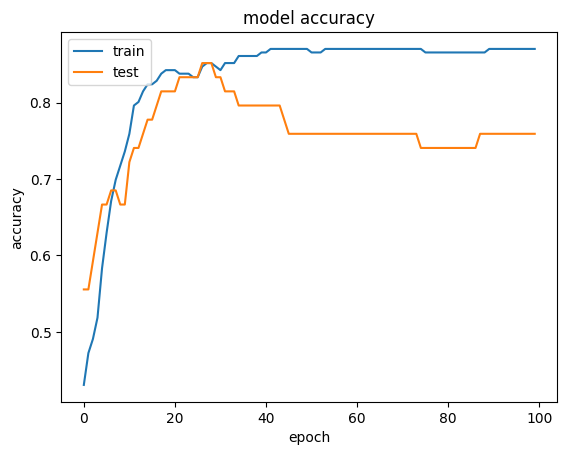

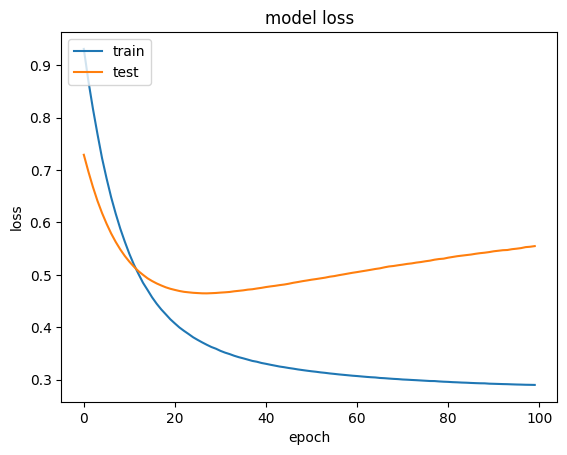

In [147]:
# TODO Afficher l'évolution de l'accuracy
plot_history(history, "accuracy")
# TODO Afficher l'évolution de la fonction de coût
plot_history(history, "loss")

# A votre tour d'essayer des combinaisons !
Essayer d'ajouter des nœuds et/ou des couches en plus, essayez de changer la fonction d'activation, ou la fonction de coût, pour voir si vous pouvez améliorer l'accuracy. Vous pouvez aussi changer le score !